- 업리프트 모델링<sup>uplift modeling</sup>: 역학<sup>epidemiology</sup> 통계나 다이렉트 마케팅에서 활용되는 머신러닝 기법.
- **무작위 비교 시험(A/B 테스트)** 데이터를 분석해 약이 어떤 환자에게 효과가 있는지, 다이렉트 메일은 어떤 고객에게 보내면 효과가 있는지 등을 예측

> 무작위 비교 시험  
> 모집단을 무작위로 실험군과 대조군 그룹으로 나눈 뒤 실험군에는 효과를 검증하려는 개입 행위를 하고 대조군에는 개입하지 않는 방법

- 업리프트 모델링은 실험군과 대조군에서 어떤 특징량을 가진 표본이 반응하는지 여부를 확인
- 이를 통해 개입 행위에 대해 특정한 표본이 얼마나 반응할지를 예측하고 효과를 보일 것으로 예측되는 대상에게만 개입 행위를 한다.


# 10.1 업리프트 모델링의 사분면

- 업리프트 모델링은 개입 유무와 **전환**<sup>Conversion</sup>(CV)을 기준으로 대상을 네 그룹으로 나눈다.

| 개입 안 함 | 개입함 | 범주 | 대응 방안 |
|---|---|---|---|
| 전환하지 않음 | 전환하지 않음 | 무관심 | 비용이 드는 개입은 자제한다. |
| 전환하지 않음 | 전환함 | 설득 가능 | 가능한 개입 대상에 포함시킨다. |
| 전환함 | 전환하지 않음 | 청개구리 | 개입 대상에 절대로 포함시키지 않는다. |
| 전환함 | 전환함 | 잡은 물고기 | 비용이 드는 개입은 자제한다. |

---

# 10.2 A/B 테스트 확장을 통한 업리프트 모델링

- 배너광고 A와 B에 대한 A/B 테스트 결과 각각의 반응률이 4.0%, 5.0%라면 A/B 테스트에서는 광고 B를 보여주는 것이 좋다고 판단
- 업리프트 모델링은 고객이 특징량을 고려
- 성별을 기준으로 A/B 테스트의 결과를 확장한 경우

| 반응률 | 배너 광고 A | 배너 광고 B |
|---|---|---|
| 남성 | 6.0% | 2.0% |
| 여성 | 2.0% | 8.0 % |
| 평균 | 4.0% | 5.0% |

- 결과적으로 남성에게는 A 광고를, 여성에게는 B 광고를 내보내는 것이 효과적이다.
- 특징량이 많아져 어떤 광고가 효과적이었는지 판단이 어려울 경우 머신러닝을 사용한다.

---

# 10.3 업리프트 모델링용 데이터셋 만들기

- 새로운 알고리즘을 구현할 때는 특성을 모르는 데이터셋을 사용하면 결과가 이상해도 원인이 데이터셋 오류인지 알고리즘 오류인지 알 수 없으니 주의해야 한다.
- 업리프트 모델링에서는 실험군과 대조군 표본이 필요하다.

In [1]:
# base_weight : 대조군이 가진 가중치
# lift_weight : 개입에 의해 달라지는 가중치

import  random

def generate_sample_data(num, seed=1):
    # 반환할 리스트 초기화
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []
    
    # 난수 생성기 초기화
    random_instance = random.Random(seed)
    
    # 데이터 설정값
    feature_num = 8 # 특징량 벡터는 8차원
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00] # 가중치가 0인 변수를 제공함으로써 모델의 견고함을 평가할 수 있다.
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]
    
    for i in range(num):
        # 난수를 이용해 특징량 벡터 생성
        feature_vector = [random_instance.random() for n in range(feature_num)]
        # 실험군 여부를 무작위로 결정
        is_treat = random_instance.choice((True, False))
        # 내부적인 전환율 계산 -> feature_vector와 base_weight의 내적
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])
        
        
        if is_treat:
            # 실험군에 속하면 lift_weight의 영향을 추가
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])
            
            
        # 실제 전환 여부 결정
        is_cv = cv_rate > random_instance.random()
        
        # 생성된 값 저장
        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)
        
    # 생성한 데이터 반환
    return is_cv_list, is_treat_list, feature_vector_list

- 과정에 대한 수식

> $ cv\_rate = 
\begin{cases}
feature\_vector ∙ base\_weight                 ...(대조군)\\
feature\_vector ∙ (base\_weight + lift\_weight) ...(실험군)
\end{cases}
$

In [2]:
generate_sample_data(2)

([False, False],
 [True, True],
 [[0.13436424411240122,
   0.8474337369372327,
   0.763774618976614,
   0.2550690257394217,
   0.49543508709194095,
   0.4494910647887381,
   0.651592972722763,
   0.7887233511355132],
  [0.8933170425576351,
   0.3898088070211341,
   0.6074379962852603,
   0.767157629147962,
   0.6958328667684435,
   0.26633056045725956,
   0.8018263669964836,
   0.5911534350013039]])

---

# 10.4 두 가지 예측 모델을 이용한 업리프트 모델링

- 대조군의 예측 모델과 실험군의 예측 모델을 조합해 개입에 따른 전화율의 변화를 예측할 수 있다.
- 예측 모델 출력과 업리프트 모델링 범주의 관계

| 대조군 예측 모델 결과 | 실험군 예측 모델 결과 | 대응 범주 |
|---|---|---|
| 낮음 | 낮음 | 무관심 |
| 낮음 | 높음 | 설득 가능 |
| 높음 | 낮음 | 청개구리 |
| 높음 | 높음 | 잡은 물고기 |

In [3]:
# 전체 전환률 확인

# train 데이터 생성
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# 데이터를 실험군(treatment)과 대조군(control)으로 나눈다.
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])
        
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))

treatment_cvr 0.031220247540463344
control_cvr 0.031905453372055505


- 고객의 특징량과 전환 여부 정보에 기반해 어떤 세그먼트가 개입에 반응했는지 확인해 최종적으로 개입을 통해 개선이 기대되는 세그먼트만 대상으로 결정

In [4]:
# 로지스틱 회귀 분류를 이용하여 전환 예측

from sklearn.linear_model import LogisticRegression

# 학습기 생성
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# 학습기 구현
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01)

- 업리프트 모델링 점수 계산
> $업리프트 모델링 점수 = \frac{실험군 예측값}{대조군 예측값}$

In [5]:
# seed 값을 바꿔 테스트 데이터를 만든다.
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# 각 학습기로 전환율 예측
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# 점수 계산(쇼ㅣㄹ험군 예측 전화율 / 대조군 예측 전환율)
# predict_proba는 각 클래스에 속할 확률의 리스트를 반환하므로 첫 번째 값만 확인한다.
# 반환 값이 numpy.ndarray 타입이므로 그대로 나눠도 요소 단위 나눗셈이 된다.
score_list = treat_score[:,1] / control_score[:,1]

- 지표 검증. 업리프트 모델링이 올바로 동작했다면 점수가 높은 곳에는 대조군의 전환율이 낮고 싦험군의 전환율이 높아야 한다.

In [6]:
import matplotlib.font_manager as fm

font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['cmb10',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'DejaVu Serif',
 'cmsy10',
 'DejaVu Sans Display',
 'cmr10',
 'DejaVu Sans',
 'STIXGeneral',
 'cmmi10',
 'cmtt10',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'STIXSizeTwoSym',
 'STIXSizeThreeSym',
 'STIXSizeOneSym',
 'DejaVu Sans Mono',
 'STIXSizeFiveSym',
 'DejaVu Sans',
 'cmss10',
 'STIXNonUnicode',
 'DejaVu Serif Display',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'cmex10',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Sans Mono',
 'Arial Rounded MT Bold',
 'American Typewriter',
 'KufiStandardGK',
 'Noto Sans Old Permic',
 'Noto Sans Newa',
 'Noto Sans Javanese',
 'Noto Sans Lydian',
 'Hiragino Maru Gothic Pro',
 'Farisi',
 'Times New Roman',
 'Noto Sans Buhid',
 'Sana',
 'Noto Sans Tai Viet',
 'Al Bayan',
 'Mukta Mahee',
 'Hiragino Sans',
 'STIXGeneral',
 'Noto San

Text(0, 0.5, '전환율')

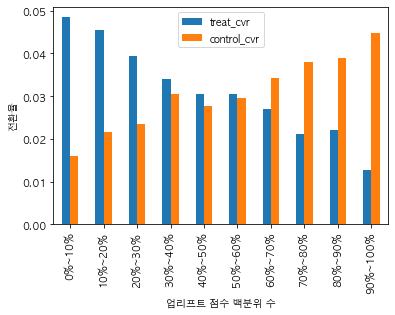

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from operator import itemgetter

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'AppleGothic'

#plt.style.use('ggplot')
#plt.rc('font', family='NanumBarunGothic')
#%matplotlib inline

# 점수가 눞은 순서대로 정렬
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    # 결과를 10% 단위로 나눈다.
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    # 실험군과 대조군에서의 결과 집계
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    # 실험군과 대조군에서 전환 건수 집계
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    # 전환 건수에서 전환율을 계산해 데이터 프레임에 저장
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n * 10, (n + 1) * 10)
    qdf.loc[label] = [treat_cvr, control_cvr]
    
qdf.plot.bar()
plt.xlabel ("업리프트 점수 백분위 수")
plt.ylabel ("전환율")

---

# 10.5 AUUC로 업리프트 모델링 평가

- AUUC 값이 클수록 업리프트 모델링 성능이 좋은 것이다.
- AUUC 계산에는 lift(특정 점수 이상인 고객에게만 개입하고 개입하지 않은 고객 대비 전환 건수가 얼마나 증가했는지 나타내는 지표)라는 지표를 사용한다.
- AUUC 계산 순서
    1. 점수가 높은 순서대로 대상을 살펴보면서 그 시점까지의 전환율을 측정
    2. 전화율의 값 차이에서 개입이 일으킨 전환 증가 건수(lift)를 계산
    3. 무작위로 개입했을 때 전환 증가 건수인 lift의 원점과 끝점을 연결한 직선을 베이스라인(base_line)으로 가정한다.
    4. lift와 base_line이 둘러싼 영역의 넓이를 계산하고 정규화해 AUUC를 구한다.

Text(0, 0.5, '전환 리프트')

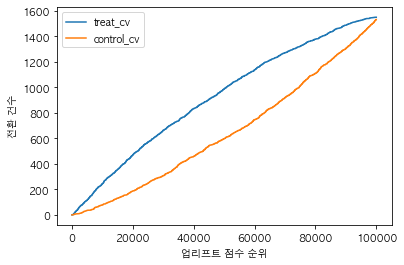

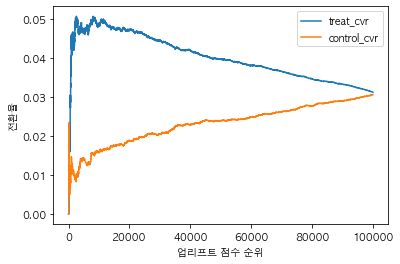

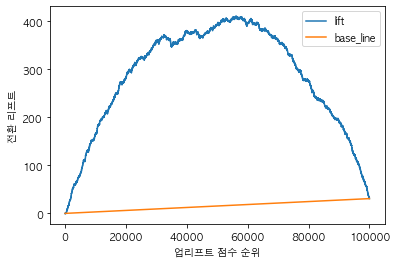

In [8]:
# 점수 순으로 집계
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0
control_cvr = 0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu
        
    # 전환율의 차이와 실험군의 사람 수를 곱해서 lift를 산출
    # 비율(CVR)의 차이이므로 실험군과 대조군의 크기가 달라도 무방하다.
    lift = (treat_cvr - control_cvr) * treat_uu
    
    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])
    
# 통계 데이터를 데이터 프레임으로 변환
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", " treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]
    
# 베이스라인 추가
df['base_line'] = df.index * df["lift"][len(df.index) - 1] / len(df.index)
    
# 시각화
df.plot(y=['treat_cv', 'control_cv'])
plt.xlabel('업리프트 점수 순위')
plt.ylabel("전환 건수")
    
df.plot(y=['treat_cvr', 'control_cvr'])
plt.xlabel('업리프트 점수 순위')
plt.ylabel('전환율')
    
df.plot(y=['lift', 'base_line'])
plt.xlabel('업리프트 점수 순위')
plt.ylabel('전환 리프트')

In [9]:
# AUUC 계산
auuc = (df['lift'] - df['base_line']).sum() / len(df['lift'])
print('AUUC: ', auuc)

AUUC:  267.03766473645675


- 개입 기준점 정하기

Text(0, 0.5, '전환 리프트')

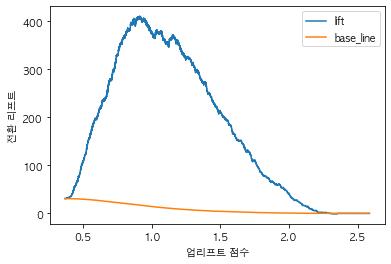

In [10]:
df.plot(x='score', y=['lift', 'base_line'])
plt.xlabel('업리프트 점수')
plt.ylabel('전환 리프트')

- 업리프트 모델링에서는 결정트리 또는 SVM을 확장한 알고리즘도 제안한다.
- 데이터셋이 동일하다면 AUUC를 이용해 파라미터나 알고리즘을 바꿔서 평가할 수도 있다.
- 실제 적용할 때에는 AUUC의 값에 기반해 여러 알고리즘을 비교하거나 파라미터를 그리드 서치 방식으로 탐색해 최적의 조건을 찾도록 한다.

---

# 10.6 실제 문제에 적용

- "The MineThatData E-Mail Analytics And Data Mining Challange" 데이터셋 이용
- 최근 1년 이내 구매 이력이 있는 고객에게 무작위로 '남성을 대상으로 메일 발송(Mens E-Mail)', 여성을 대상으로 메일 발송(Womens E-Mail)', 메일을 보내지 않는다(No E-Mail)'는 세 가지 행동을 한 후 사이트 방문으로 이어졌는지, 제품을 구매했는지 등을 조사.

In [11]:
import urllib.request
csv_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
csv_filename = "source_data.csv"
with open(csv_filename, "w") as fp:
    data = urllib.request.urlopen(csv_url).read()
    fp.write(data.decode("ascii"))

In [12]:
import pandas as pd

source_df = pd.read_csv(csv_filename)
source_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0


In [13]:
# No E0Mail은 실험 데이터에서 제외

mailed_df = source_df[source_df["segment"] != "No E-Mail"]
mailed_df = mailed_df.reset_index(drop=True)
mailed_df.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
5,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
6,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
7,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
8,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0
9,7,5) $500 - $750,548.91,0,1,Urban,1,Phone,Womens E-Mail,1,0,0.0


In [22]:
# 범주형 변수는 더미 변수로 변환 처리

dummied_df = pd.get_dummies(mailed_df[["zip_code", "channel"]], drop_first=True)
feature_vector_df = mailed_df.drop(
    ["history_segment", "zip_code", "channel", 
     "segment", "visit", "conversion", "spend"], 
     axis=1)
feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head(10)

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0
5,9,280.20,1,0,1,1,0,1,0
6,9,46.42,0,1,0,0,1,1,0
7,9,675.07,1,1,1,0,0,1,0
8,10,32.84,0,1,1,0,1,0,1
9,7,548.91,0,1,1,0,1,1,0


In [23]:
# 남성 대상 메일을 보낸 쪽에 실험군 플래그(treat), 사이트 방문을 전환 플래그(visit)를 붙인다.

is_treat_list = list(mailed_df["segment"] == "Mens E-Mail")
is_cv_list = list(mailed_df["visit"] == 1)

In [26]:
# 사이킷런의 train_test_split을 이용해 학습 데이터와 훈련 데이터를 부작위로 분리

from sklearn.model_selection import train_test_split

train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, train_feature_vector_df, test_feature_vector_df = train_test_split(
    is_cv_list, is_treat_list, feature_vector_df, test_size=0.5,  random_state=42)

# index 리셋

train_feature_vector_df = train_feature_vector_df.reset_index(drop=True)
test_feature_vector_df = test_feature_vector_df.reset_index(drop=True)

In [27]:
# 실험군과 대조군의 학습기를 만들어 학습
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01, max_iter=1000)
control_model = LogisticRegression(C=0.01, max_iter=1000)

train_sample_num = len(train_is_cv_list)

treat_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == True]
treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]

control_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == False]
control_feature_vector_list = train_feature_vector_df[list(map(lambda a:a == False ,train_is_treat_list))]

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, max_iter=1000)

In [28]:
from operator import itemgetter
    
treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)
score_list = treat_score[:,1] / control_score[:,1]

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2),reverse=True)
    

treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # 전환율의 라와 실험군의 수를 곱해서 lift를 산출
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

Text(0, 0.5, '전환율')

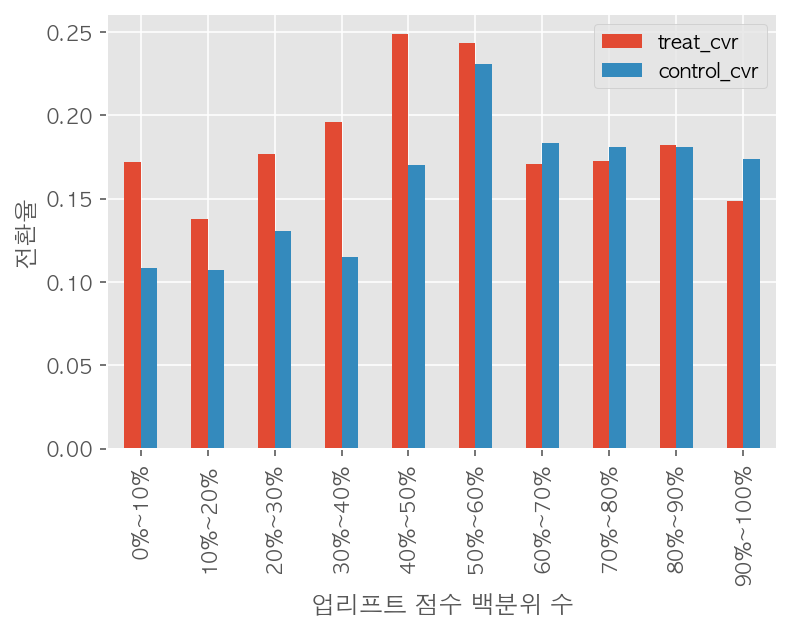

In [31]:
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'AppleGothic'

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

quantile_data = []
for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    
    quantile_data.append([treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr])
        
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("업리프트 점수 백분위 수")
plt.ylabel("전환율")

<AxesSubplot:title={'center':'lift'}, xlabel='score'>

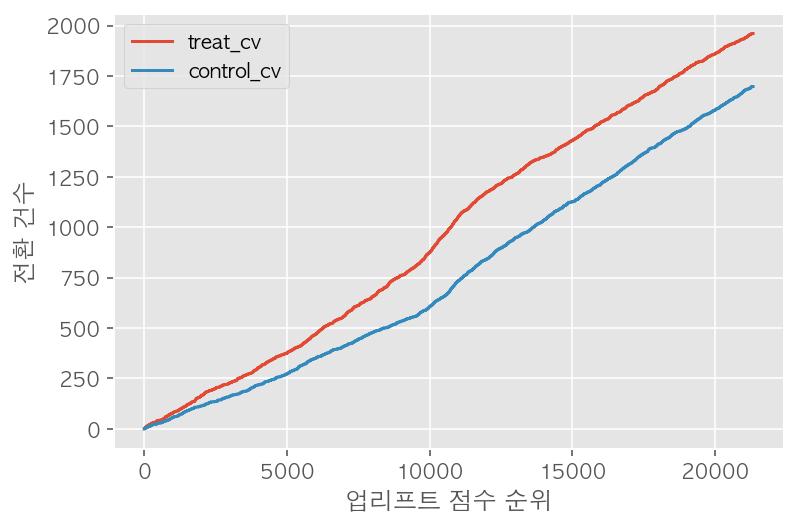

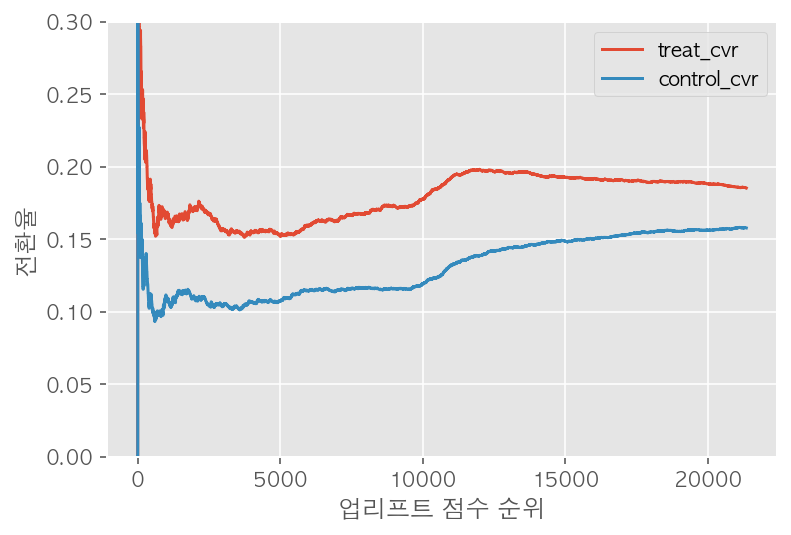

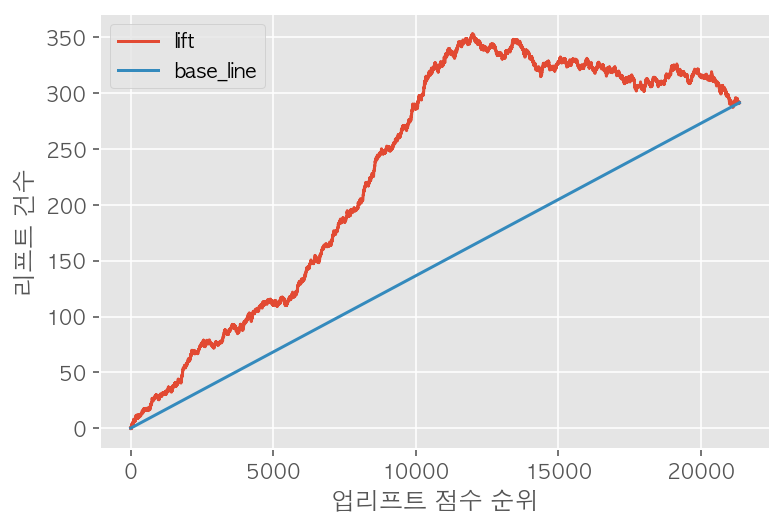

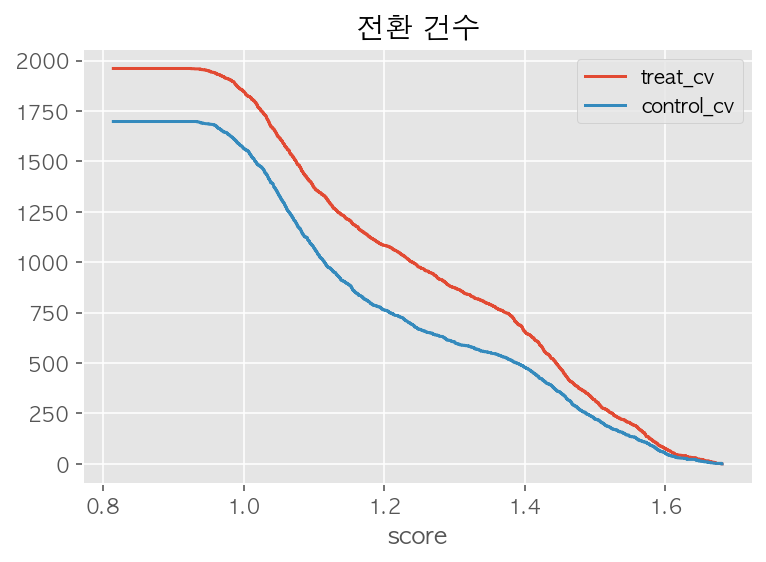

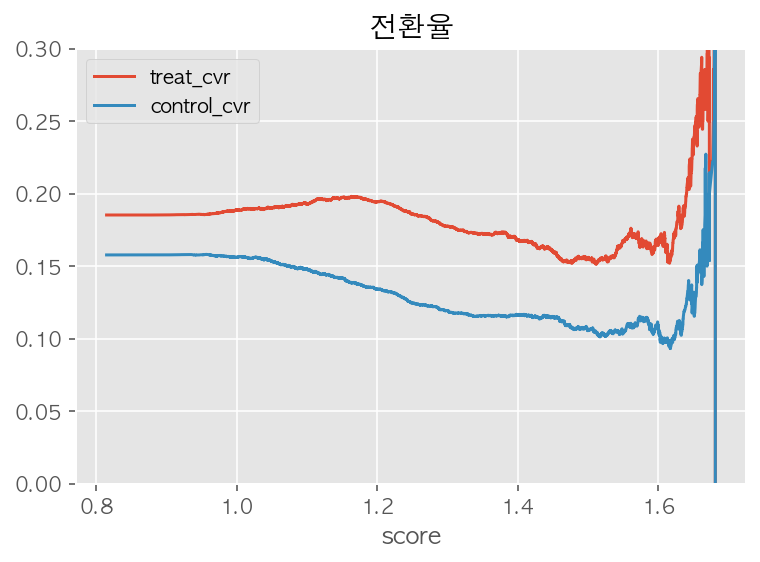

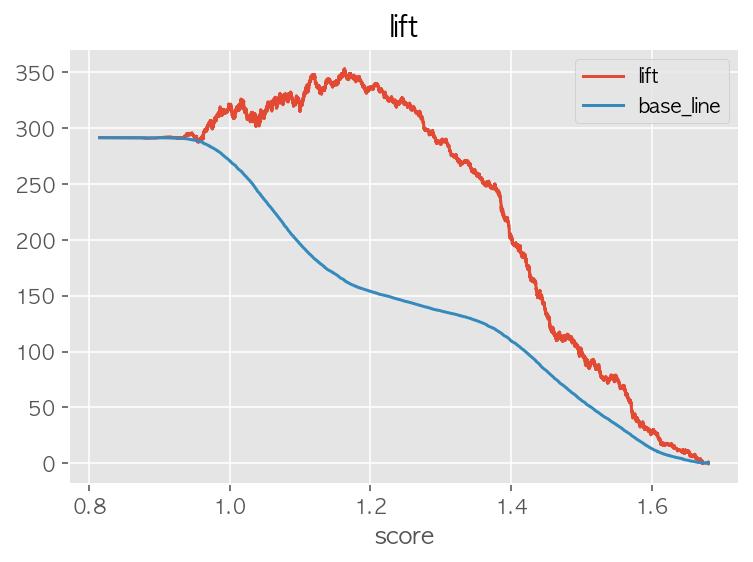

In [32]:
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]


# 베이스라인 추가
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 건수")

df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환율")

df.plot(y=["lift", "base_line"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("리프트 건수")

df.plot(y=["treat_cv", "control_cv"], x="score", title="전환 건수")
df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3], x="score", title="전환율")
df.plot(y=["lift", "base_line"], x="score", title="lift")

---

# 10.7 업리프트 모델링을 서비스에 적용

- 업리프트 모델링을 실제 서비스에 적용하기 위한 과정
    1. 실험하려는 개입을 설계하고 실험군과 대조군에 각각 무엇을 할지 결정한다.
    2. 일부 고객을 대상으로 무작위 비교 시험을 한다.
    3. 무작위 비교 실험 결과를 학습 데이터와 테스트 데이터로 나눈다.
    4. 학습 데이터를 이용해 업리프트 모델링 예측기를 만든다.
    5. 테스트 데이터를 이용해 업리프트 모델링 점수 에측 결과를 그래프로 그리고 점수 추이를 확인한다.
    6. 업리프트 모델링 점수 그래프를 통해 개입할 고객의 범위를 결정한다.
    7. 전체 고객을 대상으로 업리프트 모델링 점수를 예측한다.
    8. 예측한 점수를 바탕으로 개입할 대상 고객을 선정한다.
    9. 선정한 고객 중 일부는 개입하지 않는 대조군, 나머지 고객은 실험군으로 설정한다.
    10. 실험군에 속하는 고객에게 개입한다.
    11. 실험군과 대조군의 전환율을 비교해 개입 효과를 측정한다.

---

# 10.8 정리

- 업리프트 모델링은 무작위 비교 시험과 고객의 특징량을 조합해 전환으로 이끌어내기 쉬운 설득 가능한 고객을 예측하는 모델을 구축하는 기법